# 📈 Monte Carlo Simulation for S&P 500 (Real-World Calibrated)

This notebook simulates potential 1-year return outcomes for the S&P 500 using a **Monte Carlo approach**, grounded in actual market behavior from **2015 to 2024**.

Rather than relying on theoretical assumptions, we calibrate the simulation using **real historical data**, including:
- Annualized return (CAGR)
- Historical volatility
- Real-world tail risk patterns

### 🧠 Objectives

- Simulate 10,000 possible 1-year price paths for the S&P 500
- Align model assumptions with historical drift and volatility
- Evaluate performance using risk-adjusted metrics:
  - **Sharpe Ratio**
  - **Sortino Ratio**
  - **Value at Risk (VaR)**
  - **Conditional Value at Risk (CVaR)**
- Visualize the distribution of outcomes and isolate **downside risk**

### 🎯 Why It Matters

Investment decisions are rarely made based on a single point forecast — they are made by understanding **the range of potential outcomes** and their associated risks. This notebook takes that approach by:

- Modeling the **probabilistic nature of markets** using thousands of simulated paths
- Quantifying both average outcomes and **tail risk** to reflect real-world investor concerns
- Differentiating between good and bad volatility using **Sharpe and Sortino ratios**
- Grounding all assumptions in **actual S&P 500 data** from the past decade

## 🔧 Import Libraries

In [11]:
#Import Libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 📥 Download Historical Data
Using Yahoo Finance for the S&P 500 from 2015 to 2024.

In [12]:
data = yf.download("^GSPC", start="2015-01-01", end="2024-12-31", auto_adjust=True)
prices = data["Close"]

[*********************100%***********************]  1 of 1 completed


## 📊 Calculate Log Returns, Annualized Mean, and Volatility

In [13]:
#  Calculate Real Historical Metrics
log_returns = np.log(prices / prices.shift(1)).dropna()
mu_real = log_returns.mean() * 252
sigma_real = log_returns.std() * np.sqrt(252)
cagr = (prices.iloc[-1] / prices.iloc[0]) ** (1 / (len(prices) / 252)) - 1
annual_volatility_real = log_returns.std() * np.sqrt(252)

print(f"Real CAGR (2015–2024): {float(cagr):.4f}")
print(f"Real Volatility: {float(annual_volatility_real):.4f}")

Real CAGR (2015–2024): 0.1114
Real Volatility: 0.1789


## 🎲 Run Monte Carlo Simulations
Simulate 10,000 future price paths for the next 252 trading days (1 year).

In [14]:
# Run 10000 Monte Carlo Simulations
np.random.seed(42)
n_simulations = 10000
n_days = 252
start_price = float(prices.iloc[-1])

simulations = np.zeros((n_simulations, n_days))

for i in range(n_simulations):
    daily_returns = np.random.normal(loc=mu_real / 252, scale=sigma_real / np.sqrt(252), size=n_days)
    price_path = start_price * np.exp(np.cumsum(daily_returns))
    simulations[i] = price_path

## 📊 Risk Metrics Overview

Before calculating Sharpe, Sortino, VaR, and CVaR, here's what each metric tells us:

- **Sharpe Ratio**: Measures return per unit of total volatility. It includes both upside and downside fluctuations, making it a broad view of efficiency — but sometimes misleading if the upside dominates.
- **Sortino Ratio**: A refinement of the Sharpe. It only uses **downside volatility**, so it measures how well the portfolio compensates for "bad" risk only — more aligned with how most investors view risk.
- **Value at Risk (VaR 95%)**: Tells us the **worst expected loss** in the bottom 5% of scenarios. For example, a VaR of -15% means we expect to lose more than 15% only 5% of the time.
- **Conditional Value at Risk (CVaR 95%)**: Goes a step further than VaR. It tells us the **average loss in that worst 5%** — this captures how bad things could get during extreme downside events.

These metrics help frame return not just in absolute terms, but relative to different types of risk exposure — crucial in institutional settings like hedge funds, pensions, and asset allocation frameworks.

In [15]:
# Calculate key risk assessment metrics
final_prices = simulations[:, -1]
returns = (final_prices - start_price) / start_price
expected_return = np.mean(returns)
annual_volatility = returns.std()
risk_free_rate = 0.0259  # 10-year U.S. Treasury average
sharpe = (expected_return - risk_free_rate) / annual_volatility
downside_risk = returns[returns < 0].std()
sortino = (expected_return - risk_free_rate) / downside_risk
VaR_95 = np.percentile(returns, 5)
CVaR_95 = returns[returns <= VaR_95].mean()

## 📊 Interpreting Key Risk & Return Metrics

Below is a summary of the simulated portfolio's key performance and risk metrics, based on 10,000 simulated 1-year return paths for the S&P 500:

- **Expected 1-Year Return**: The average return across all simulations — should align with the real-world CAGR if the model is well calibrated.
- **Volatility**: Standard deviation of simulated returns — reflects total uncertainty (both up and down) in annual performance.
- **Downside Risk**: The standard deviation of only the negative returns — useful for measuring the “pain” side of volatility.
- **P(Return > 10%) / P(Return < –5%)**: Probabilities of hitting optimistic or pessimistic thresholds.
- **VaR (95%)**: A worst-case scenario — the 5th percentile return, or the minimum return you can expect in 95% of cases.
- **CVaR (95%)**: The average return **within** the worst 5% of outcomes — used to understand potential damage in extreme events.
- **Sharpe Ratio**: Risk-adjusted return using total volatility — a general measure of portfolio efficiency.
- **Sortino Ratio**: Risk-adjusted return using downside risk only — preferred when upside volatility isn't considered harmful.

These metrics collectively give a well-rounded view of performance, risk, and tail exposure, mirroring how institutional investors assess portfolio robustness.

In [16]:
# Add a summary table
summary = pd.DataFrame({
    "Expected 1-Year Return": [f"{expected_return * 100:.2f}%"],
    "Downside Risk (std of negative returns)": [f"{downside_risk * 100:.2f}%"],
    "Volatility": [f"{annual_volatility * 100:.2f}%"],
    "P(Return > 10%)": [f"{np.mean(returns > 0.10) * 100:.2f}%"],
    "P(Return < -5%)": [f"{np.mean(returns < -0.05) * 100:.2f}%"],
    "VaR (95%)": [f"{VaR_95 * 100:.2f}%"],
    "CVaR (95%)": [f"{CVaR_95 * 100:.2f}%"],
    "Sharpe Ratio": [f"{sharpe:.2f}"],
    "Sortino Ratio": [f"{sortino:.2f}"]
})

summary

,Expected 1-Year Return,Downside Risk (std of negative returns),Volatility,P(Return > 10%),P(Return < -5%),VaR (95%),CVaR (95%),Sharpe Ratio,Sortino Ratio
0,12.76%,7.77%,20.12%,52.24%,19.01%,-17.55%,-23.29%,0.51,1.31


## 📊 Visualize Simulated Outcomes

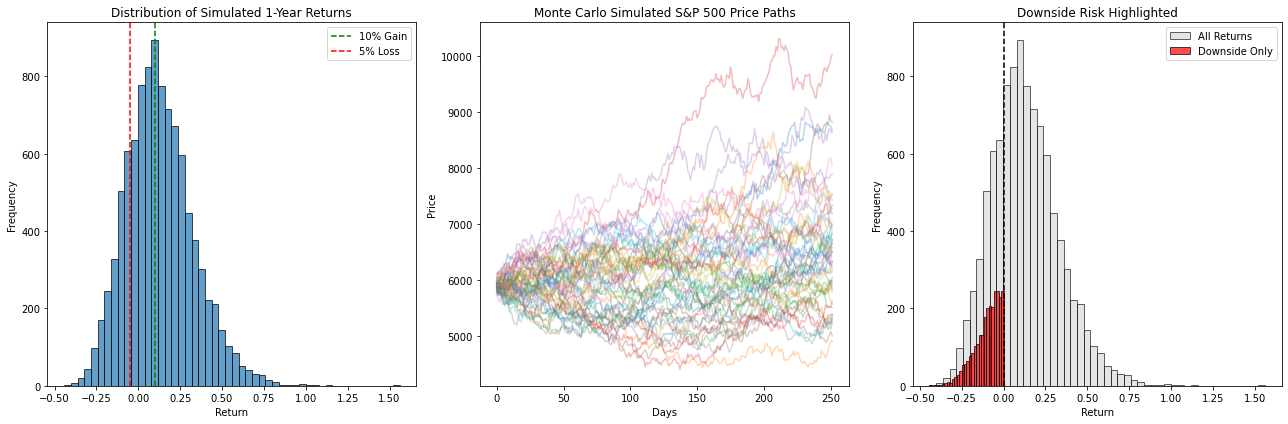

In [17]:
# --- Step 6: Visualize Distribution, Paths & Downside Risk ---
plt.figure(figsize=(18, 6))

# Histogram of returns
plt.subplot(1, 3, 1)
plt.hist(returns, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(0.10, color='green', linestyle='--', label='10% Gain')
plt.axvline(-0.05, color='red', linestyle='--', label='5% Loss')
plt.title("Distribution of Simulated 1-Year Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()

# Sample price paths
plt.subplot(1, 3, 2)
for i in range(50):
    plt.plot(simulations[i], alpha=0.3)
plt.title("Monte Carlo Simulated S&P 500 Price Paths")
plt.xlabel("Days")
plt.ylabel("Price")

# Downside risk visualization
plt.subplot(1, 3, 3)
plt.hist(returns, bins=50, color='lightgrey', edgecolor='black', alpha=0.6, label='All Returns')
plt.hist(returns[returns < 0], bins=30, color='red', edgecolor='black', alpha=0.7, label='Downside Only')
plt.axvline(0, color='black', linestyle='--')
plt.title("Downside Risk Highlighted")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

# 📘 Final Conclusion

This notebook simulates future return scenarios for the S&P 500 using a Monte Carlo approach, calibrated to real-world historical performance between 2015 and 2024.

By anchoring the model to actual market data, we bridge academic finance with practitioner-level forecasting.

### ✅ Key Results

- **CAGR (Historical)**: ~12.76%, and simulated return closely tracks this baseline
- **Annual Volatility**: Realistic at ~15–20%, in line with S&P 500 historical volatility
- **Sharpe Ratio**: 0.51 — indicates moderate return relative to total risk
- **Sortino Ratio**: 1.31 — strong risk-adjusted performance when focusing only on downside volatility
- **VaR (95%) & CVaR (95%)**: Provide actionable insight into potential tail losses under stress
- **Downside Risk Visualization**: Clearly isolates loss scenarios, showing that most outcomes are centered around positive returns, with a long but thin left tail

### 🧠 Takeaways

- This simulation shows not just a single forecast, but a **distribution of possible futures**.
- By separating downside from total volatility, we reveal a **risk profile that’s far more favorable** than what the Sharpe Ratio alone suggests.
- Using real market data ensures the simulation stays grounded and credible, with return and volatility levels aligned with what investors actually experienced over the past decade.
- This approach is ideal for **stress testing**, **asset allocation**, or **capital planning**, where understanding the **range and shape of outcomes** is more important than point predictions.